In [278]:
from importlib import reload
import time
import joblib
from pylab import *
from tqdm import tqdm


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)



<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

# Step 1: connect to the scope
- If you don't know the address, do vs.connect()
- Otherwise, put the address in the argument will speed it up

In [279]:
scope = vs.connect(address = "USB0::0x2A8D::0x9008::MY63160110::0::INSTR", timeout=30_000) # set 30 second

Connected to VISA [USB0::0x2A8D::0x9008::MY63160110::0::INSTR]:  KEYSIGHT TECHNOLOGIES,EXR054A,MY63160110,11.50.00201



# Example 1: read the current waveform from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

In [280]:
def read_waveform_cuts(scope, trigger_channel = 1, read_channel = [1,2], acquire_length = 4096, calibrate = True, initialize = False, calibration_data=None, trigger_mode="normal"):

    if initialize:
        # Trigger
        scope.write(":TRIGger:MODE EDGE")
        scope.write(f":TRIGger:EDGE:SOURce CHANnel{trigger_channel}") #CHANNEL 1 TRIGGER
        # scope.write(":TRIGger:EDGE:SLOPe NEGative")

        # Acquisation setup
        if trigger_mode == "normal":
            scope.write(":ACQuire:TYPE NORMal")
        else:
            scope.write(":ACQuire:TYPE AUTO")

        scope.write(":ACQuire:MODE RTIMe") # Realtime acquire mode
        scope.write(":ACQuire:INTerpolate 0") # Disable interpolation
        scope.write(f":ACQuire:POINts:ANALog {acquire_length}")
        
        # Other settings
        scope.write(":SYSTem:HEADer OFF")# ' Response headers off.
        scope.write(":WAVeform:FORMat WORD")# ' Select word format.
        scope.write(":WAVeform:BYTeorder LSBFirst")# ' Select word format.
        scope.write(":WAVeform:STReaming 0")#        
        
        for ch in read_channel:
            scope.write(f":CHANnel{ch}:DISPlay ON")        
        
        
    # Additional cut on triggered events
    trigger_condition = False
    n_trys = 30
    while (trigger_condition is False) and (n_trys>0):
        # Digitize, and display
        # The command runs x10 faster without parameters... Keep the digitize command as is and set the channel on scope
        digi_command = ":DIGitize "
        # for ch in read_channel:
        #     digi_command+=f"CHANnel{ch},"
        # digi_command = digi_command[:-1]
        scope.write(digi_command);

        # Cut on amplitude
        scope.write(":MEASure:SOURce CHANnel2");
        # scope.write(":MEASure:VMAX");
        # print(scope.query(":MEASure:VMIN?"))
        amp = np.abs(float(scope.query(":MEASure:VMAX?")))
        if amp>0.006:
            trigger_condition=True

        n_trys-=1
   

    data={}
    for ch in read_channel:

        # Copy the waveform
        scope.write(f":WAVeform:SOURce CHANnel{ch}")# Select source.
        scope.write(":WAVeform:DATA?")#
        varWavData = np.array(scope.read_binary_values(datatype='h'))
        
        if calibrate:
            # Calibration
            if calibration_data is None:
                dx = float(scope.query(":WAVeform:XINCrement?")[:-1])
                dy = float(scope.query(":WAVeform:YINCrement?")[:-1])
                x0 = float(scope.query(":WAVeform:XORigin?")[:-1])
                y0 = float(scope.query(":WAVeform:YORigin?")[:-1])
            else:
                dx,dy,x0,y0 = calibration_data[ch]
            varWavData = varWavData*dy + y0
            time_series = np.arange(len(varWavData))*dx + x0
        else:
            time_series = np.arange(len(varWavData))
        # Float32 is enough for 16-bit integer    
        data[ch] = varWavData.astype(np.float32)
        
    return data, time_series   


def get_events_cuts(scope, Nevents = 100, trigger_channel = 1, read_channel = [1,2], acquire_length = 4096, calibrate = True, print_every_n = 10):
    # Test:
    # data_save = get_events(scope, Nevents = 10, trigger_channel = 1, read_channel = [1,2], acquire_length = 4096, calibrate = True, print_every_n = 1)

    n_acquired = 0 
    data_save = {}
    for ch in read_channel:
        data_save[ch]=[]
        
        
    # Initialize settings:
    data,time_series=read_waveform_cuts(scope, trigger_channel = 1, read_channel = [1,2], acquire_length = 4096, calibrate = False, initialize = True, calibration_data=None)
    # Get the calibration 
    calibration_data = vs.get_calibration(scope)
    
    
    # Start repetitive acquisation
    t1=time.time()   
    t2a=t1
    while(n_acquired<Nevents):
        try:
            data, time_series=read_waveform_cuts(scope, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = calibrate, initialize = False, calibration_data=calibration_data)
            for i, ch in enumerate(read_channel):
                data_save[ch].append(data[ch][:])
            n_acquired+=1  
            if n_acquired%print_every_n ==0:
                t2b=time.time()
                print(f"{n_acquired}/{Nevents} events acquired, time elapsed {t2b - t1:.1f} s, time from last print {t2b-t2a:.1f} s")
                t2a=t2b
                
            del data
        except KeyboardInterrupt:
            print("  KeyboardInterrupt. You pressed ctrl c...")
            break                
        except Exception as e: # Any other exception
            print("  Exception:", str(e)) # Displays the exception without raising it
            continue
            
    data_save["metadata"]={}
    data_save["metadata"]["time_series"]=time_series
    return data_save

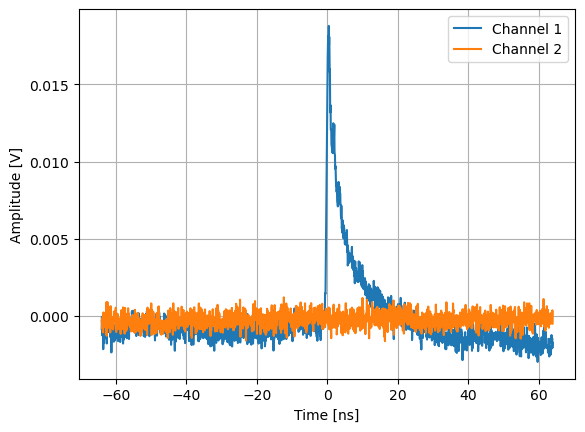

In [302]:
trigger_channel = 1
read_channel = [1,2]
acquire_length = 2048

data,time_series=read_waveform_cuts(scope, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True, initialize = True, calibration_data=None)
# data,time_series=vs.read_waveform(scope, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True, initialize = True, calibration_data=None)

for ch in data:
    plot(time_series*1e9, data[ch], label=f"Channel {ch}")

# xlim(-10,10)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
legend()
grid()

# Example 2: repetitively read multiple waveforms from the scope

- For simplicity of the code and better readout speed, please configure the trigger threshold and channel setup on the scope

In [274]:
# data_save = vs.get_events(scope, Nevents = 40, print_every_n = 4, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
data_save = get_events_cuts(scope, Nevents = 40, print_every_n = 4, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
time_series = data_save["metadata"]["time_series"]*1e9


4/40 events acquired, time elapsed 1.4 s, time from last print 1.4 s
8/40 events acquired, time elapsed 2.6 s, time from last print 1.1 s
12/40 events acquired, time elapsed 4.3 s, time from last print 1.7 s
16/40 events acquired, time elapsed 6.0 s, time from last print 1.8 s
20/40 events acquired, time elapsed 7.1 s, time from last print 1.1 s
24/40 events acquired, time elapsed 10.2 s, time from last print 3.1 s
28/40 events acquired, time elapsed 12.3 s, time from last print 2.0 s
32/40 events acquired, time elapsed 14.1 s, time from last print 1.9 s
36/40 events acquired, time elapsed 15.3 s, time from last print 1.2 s
40/40 events acquired, time elapsed 16.8 s, time from last print 1.5 s


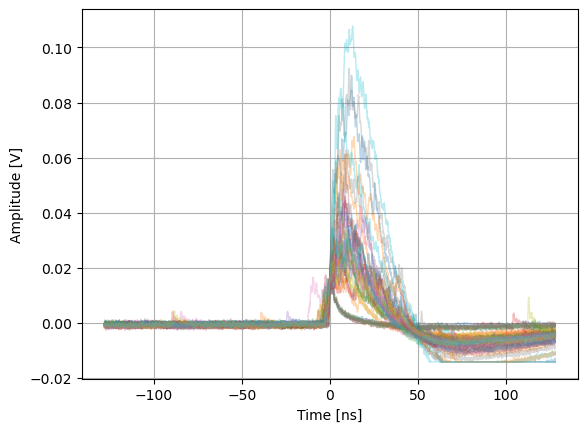

In [276]:

for i in range(len(data_save[1])):
    plot(time_series, data_save[1][i],alpha=0.3, linewidth=1)

# xlim(-10,10)
xlabel("Time [ns]")
ylabel("Amplitude [V]")
grid()

# Acquire the data

In [277]:
data_save = get_events_cuts(scope, Nevents = 7200, print_every_n = 400, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "data_waveform/waveform_fiber_Y11.joblib",compress =False) # Dark current on CH1 and CH2, threshold CH1=1 mV 0.5 eh


400/7200 events acquired, time elapsed 170.7 s, time from last print 170.7 s
800/7200 events acquired, time elapsed 344.2 s, time from last print 173.5 s
1200/7200 events acquired, time elapsed 524.8 s, time from last print 180.6 s
1600/7200 events acquired, time elapsed 697.0 s, time from last print 172.2 s
2000/7200 events acquired, time elapsed 881.0 s, time from last print 184.0 s
2400/7200 events acquired, time elapsed 1046.8 s, time from last print 165.8 s
2800/7200 events acquired, time elapsed 1213.3 s, time from last print 166.5 s
3200/7200 events acquired, time elapsed 1378.8 s, time from last print 165.5 s
  Exception: VI_ERROR_IO (-1073807298): Could not perform operation because of I/O error.
  Exception: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
3600/7200 events acquired, time elapsed 1598.0 s, time from last print 219.2 s
4000/7200 events acquired, time elapsed 1775.4 s, time from last print 177.4 s
4400/7200 events acquired, time elapsed 19

['data_waveform/waveform_fiber_Y11.joblib']

In [32]:
# Calibration, laser, low intensity
data_save = vs.get_events(scope, Nevents = 1200, print_every_n = 400, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "data_waveform/waveform_calib_CH1.joblib",compress =False) # Laser on CH2, TTL trigger on CH1, laser ~3 eh


400/1200 events acquired, time elapsed 6.2 s, time from last print 6.2 s
800/1200 events acquired, time elapsed 12.4 s, time from last print 6.2 s
1200/1200 events acquired, time elapsed 18.5 s, time from last print 6.1 s


['data_waveform/waveform_calib_CH1.joblib']

In [8]:
# Calibration, laser, high intensity
data_save = vs.get_events(scope, Nevents = 7200, print_every_n = 400, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "waveform_laser.joblib",compress =False) # Laser on CH2, TTL trigger on CH1, laser ~3 eh


400/7200 events acquired, time elapsed 10.4 s, time from last print 10.4 s
800/7200 events acquired, time elapsed 21.0 s, time from last print 10.7 s
1200/7200 events acquired, time elapsed 31.4 s, time from last print 10.4 s
1600/7200 events acquired, time elapsed 41.8 s, time from last print 10.3 s
2000/7200 events acquired, time elapsed 52.1 s, time from last print 10.3 s
2400/7200 events acquired, time elapsed 62.5 s, time from last print 10.4 s
2800/7200 events acquired, time elapsed 73.0 s, time from last print 10.5 s
3200/7200 events acquired, time elapsed 83.4 s, time from last print 10.4 s
3600/7200 events acquired, time elapsed 93.7 s, time from last print 10.3 s
4000/7200 events acquired, time elapsed 104.0 s, time from last print 10.3 s
4400/7200 events acquired, time elapsed 114.4 s, time from last print 10.4 s
4800/7200 events acquired, time elapsed 124.7 s, time from last print 10.4 s
5200/7200 events acquired, time elapsed 135.3 s, time from last print 10.6 s
5600/7200 

['waveform_laser.joblib']

In [7]:
# Ch1 CH2 coincidence
data_save = vs.get_events(scope, Nevents = 7200, print_every_n = 400, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
# joblib.dump(data_save, "muon_coinc_ch1_ch2.joblib",compress =False) # threshold CH1=20 mV ~8eh
# joblib.dump(data_save, "muon_coinc_ch1_ch2_coinc.joblib",compress =False) # threshold CH1=10 mV ~8eh && CH2=10 mV ~8eh

400/7200 events acquired, time elapsed 251.1 s, time from last print 251.1 s
800/7200 events acquired, time elapsed 508.3 s, time from last print 257.2 s
1200/7200 events acquired, time elapsed 771.9 s, time from last print 263.6 s
1600/7200 events acquired, time elapsed 1026.7 s, time from last print 254.8 s
2000/7200 events acquired, time elapsed 1290.8 s, time from last print 264.0 s
2400/7200 events acquired, time elapsed 1551.7 s, time from last print 261.0 s
2800/7200 events acquired, time elapsed 1806.2 s, time from last print 254.4 s
3200/7200 events acquired, time elapsed 2081.2 s, time from last print 275.0 s
3600/7200 events acquired, time elapsed 2358.8 s, time from last print 277.7 s
4000/7200 events acquired, time elapsed 2621.3 s, time from last print 262.4 s
4400/7200 events acquired, time elapsed 2853.2 s, time from last print 232.0 s
4800/7200 events acquired, time elapsed 3121.1 s, time from last print 267.9 s
5200/7200 events acquired, time elapsed 3379.7 s, time fr

['muon_coinc_ch1_ch2_coinc.joblib']

In [11]:
# Laser+WLS
data_save = vs.get_events(scope, Nevents = 5000, print_every_n = 500, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "waveform_laser.joblib",compress =False) # CH1: trigger, CH2: laser, mean~20mV


500/5000 events acquired, time elapsed 12.6 s, time from last print 12.6 s
1000/5000 events acquired, time elapsed 25.3 s, time from last print 12.7 s
1500/5000 events acquired, time elapsed 37.9 s, time from last print 12.6 s
2000/5000 events acquired, time elapsed 50.5 s, time from last print 12.6 s
2500/5000 events acquired, time elapsed 63.2 s, time from last print 12.7 s
3000/5000 events acquired, time elapsed 75.7 s, time from last print 12.6 s
3500/5000 events acquired, time elapsed 88.5 s, time from last print 12.7 s
4000/5000 events acquired, time elapsed 101.1 s, time from last print 12.7 s
4500/5000 events acquired, time elapsed 113.9 s, time from last print 12.8 s
5000/5000 events acquired, time elapsed 126.7 s, time from last print 12.8 s


['waveform_laser.joblib']

In [28]:
data_save = vs.get_events(scope, Nevents = 2000, print_every_n = 200, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "waveform_scintillator.joblib",compress =False)

200/2000 events acquired, time elapsed 100.7 s, time from last print 100.7 s
400/2000 events acquired, time elapsed 207.5 s, time from last print 106.7 s
600/2000 events acquired, time elapsed 315.7 s, time from last print 108.2 s
800/2000 events acquired, time elapsed 421.3 s, time from last print 105.7 s
1000/2000 events acquired, time elapsed 519.9 s, time from last print 98.6 s
1200/2000 events acquired, time elapsed 622.2 s, time from last print 102.3 s
1400/2000 events acquired, time elapsed 726.9 s, time from last print 104.7 s
1600/2000 events acquired, time elapsed 832.6 s, time from last print 105.6 s
1800/2000 events acquired, time elapsed 936.0 s, time from last print 103.4 s
2000/2000 events acquired, time elapsed 1041.6 s, time from last print 105.6 s


In [62]:
# Calibration, dark current
data_save = vs.get_events(scope, Nevents = 7200, print_every_n = 400, trigger_channel = trigger_channel, read_channel = read_channel, acquire_length = acquire_length, calibrate = True)
joblib.dump(data_save, "calibration_ch1.joblib",compress =False) # Dark current on CH1


400/7200 events acquired, time elapsed 5.7 s, time from last print 5.7 s
800/7200 events acquired, time elapsed 11.5 s, time from last print 5.8 s
1200/7200 events acquired, time elapsed 17.2 s, time from last print 5.7 s
1600/7200 events acquired, time elapsed 22.9 s, time from last print 5.7 s
2000/7200 events acquired, time elapsed 28.7 s, time from last print 5.8 s
2400/7200 events acquired, time elapsed 34.3 s, time from last print 5.7 s
2800/7200 events acquired, time elapsed 40.2 s, time from last print 5.8 s
3200/7200 events acquired, time elapsed 46.0 s, time from last print 5.8 s
3600/7200 events acquired, time elapsed 51.6 s, time from last print 5.7 s
4000/7200 events acquired, time elapsed 57.3 s, time from last print 5.7 s
4400/7200 events acquired, time elapsed 63.0 s, time from last print 5.7 s
4800/7200 events acquired, time elapsed 68.8 s, time from last print 5.8 s
5200/7200 events acquired, time elapsed 74.7 s, time from last print 5.9 s
5600/7200 events acquired, t

['calibration_ch1.joblib']